In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import pickle
import transformers
from matplotlib.lines import Line2D
import seaborn as sns
import json
from sklearn.manifold import TSNE
import torch
from sklearn.decomposition import DictionaryLearning, PCA, KernelPCA
from data_provider.data_split_recorder import split_recorder
from Prompts.Mapping_helper import Mapping_helper
def set_ax_linewidth(ax, bw=1.5):
    ax.spines['bottom'].set_linewidth(bw)
    ax.spines['left'].set_linewidth(bw)
    ax.spines['top'].set_linewidth(bw)
    ax.spines['right'].set_linewidth(bw)

def set_ax_font_size(ax, fontsize=10):
    ax.tick_params(axis='y',
                 labelsize=fontsize # y轴字体大小设置
                  ) 
    ax.tick_params(axis='x',
                 labelsize=fontsize # x轴字体大小设置
                  ) 

def set_draft(the_plt, other_ax=''):
    ax = the_plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.xlabel('')
    plt.ylabel('')
    if other_ax:
        other_ax.axes.xaxis.set_ticklabels([])
        other_ax.axes.yaxis.set_ticklabels([])
        other_ax.set_ylabel('')
        other_ax.set_xlabel('')

def set_draft_fig(fig):
    for ax in fig.axes:
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.set_ylabel('')
        ax.set_xlabel('')

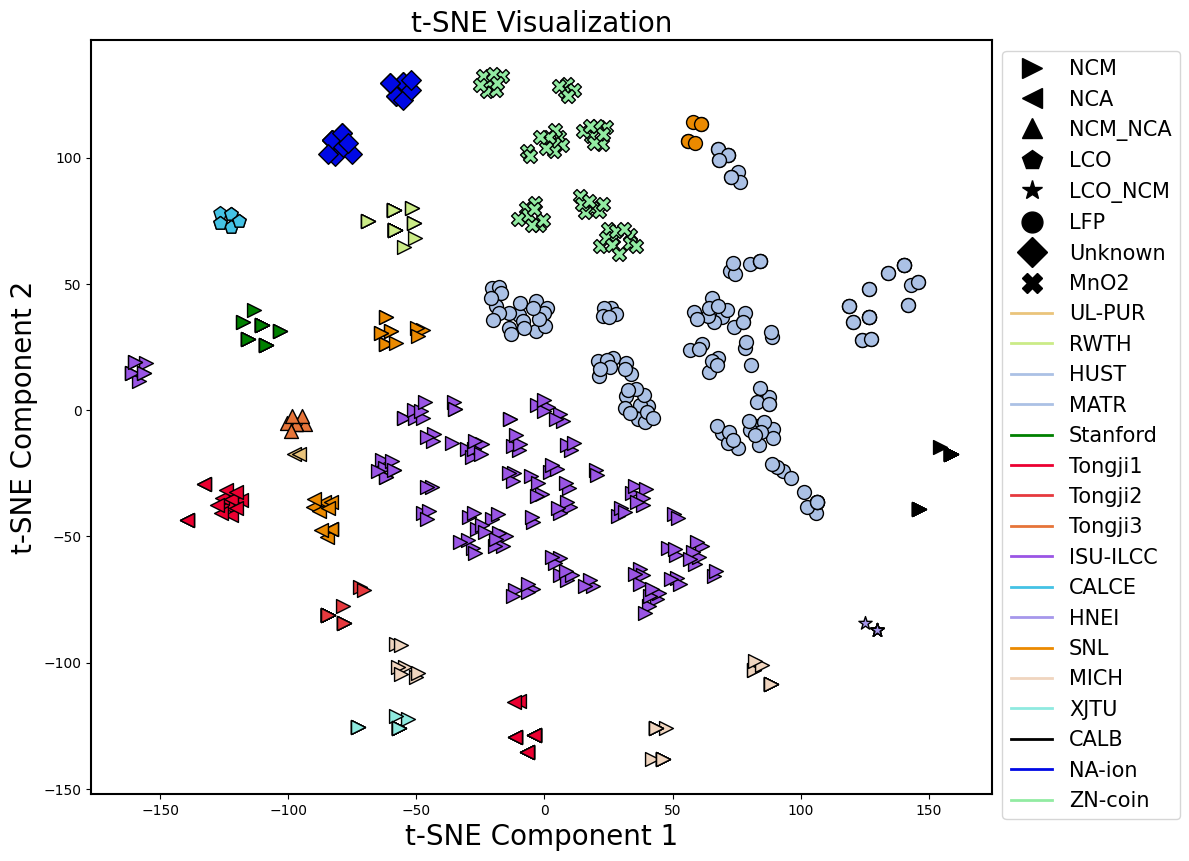

In [5]:
def array_in_list(arr, list_of_arrays):
    return any(np.array_equal(arr, existing_arr) for existing_arr in list_of_arrays)

model_name = 'Qwen3_8B' # ['Qwen3_0.6B', 'Qwen3_8B']
data_path = f'/data/trf/python_works/BatteryLife/dataset/training_DKP_embed_all_{model_name}.pkl'
data = pickle.load(open(data_path, 'rb'))
tmp_total_features = np.array(list(data.values())).squeeze(1)



names = list(data.keys())


# Perform t-SNE on the embeddings (total_features)
# tsne = TSNE(n_components=2, random_state=42, perplexity=8)  # Reduce to 2D for visualization
# tsne_results = tsne.fit_transform(tmp_total_features)

tsne = TSNE(n_components=2, random_state=42, perplexity=8)  # Reduce to 2D for visualization
tsne_results = tsne.fit_transform(tmp_total_features)
dataset_names = [name.split('_')[0] for name in names]

fig = plt.figure(figsize=(12, 9))
# Define a list of different shapes for the clusters
cathodes_data = json.load(open('./gate_data/cathodes.json'))
cathode_names = ['_'.join(cathodes_data[i+'.pkl']) for i in names]

dataset_shape_map = {
    'NCM': '>',
    'NCA': '<',
    'NCM_NCA':'^',
    'LCO': 'p',
    'LCO_NCM': '*',
    'LFP': 'o',
    'Unknown': 'D',
    'MnO2': 'X'
}

dataset_color = {
    'UL-PUR': '#EAC47B',
    'RWTH': '#CBEB87',
    'HUST':'#ABC1E5',
    'MATR': '#ABC1E5',
    'Stanford': 'green',
    'Tongji1': '#EB0031',
    'Tongji2': '#E6393E',
    'Tongji3': '#E67439',
    'ISU-ILCC': '#9A55E5',
    'CALCE': '#44C2E5',
    'HNEI': '#A697EB',
    'SNL': '#EB8A00',
    'MICH': '#F0D5BF',
    'XJTU': '#8FEAE0',
    'CALB': 'black',
    'NA-ion': '#0009E5',
    'ZN-coin': '#92EBA2'
}

appear_cathodeNames = []
for i in range(len(tmp_total_features)):
    if cathode_names[i] not in appear_cathodeNames:
        plt.scatter(tsne_results[i, 0], tsne_results[i, 1],
                    c=dataset_color[dataset_names[i]],  # Color by cluster label
                    marker=dataset_shape_map[cathode_names[i]],  # Shape by dataset name
                     s=100, edgecolor='k', label=cathode_names[i])
    else:
        plt.scatter(tsne_results[i, 0], tsne_results[i, 1],
                    c=dataset_color[dataset_names[i]],  # Color by cluster label
                    marker=dataset_shape_map[cathode_names[i]],  # Shape by dataset name
                    s=100, edgecolor='k')
    appear_cathodeNames.append(cathode_names[i])

# Add labels and title
plt.title("t-SNE Visualization", fontsize=20)
plt.xlabel("t-SNE Component 1", fontsize=20)
plt.ylabel("t-SNE Component 2", fontsize=20)

# Custom legend for cluster shapes only (no color distinction)
legend_shapes = [Line2D([], [], marker=shape, color='black', linestyle='None', markersize=15, label=name) for name, shape in dataset_shape_map.items()]
legend_colors = [Line2D([], [], marker='None', color=color, linestyle='-', markersize=15, label=name, lw=2) for name, color in dataset_color.items()]
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1), fontsize=15, handles=legend_shapes+legend_colors)

set_ax_linewidth(plt.gca())
fig.tight_layout()
plt.savefig('./figures/t-SNE_clustering.jpg', dpi=600, bbox_inches='tight')
plt.show()

## PCA

The dimension is reduced to 35 from 4096, and 99% information is kept.


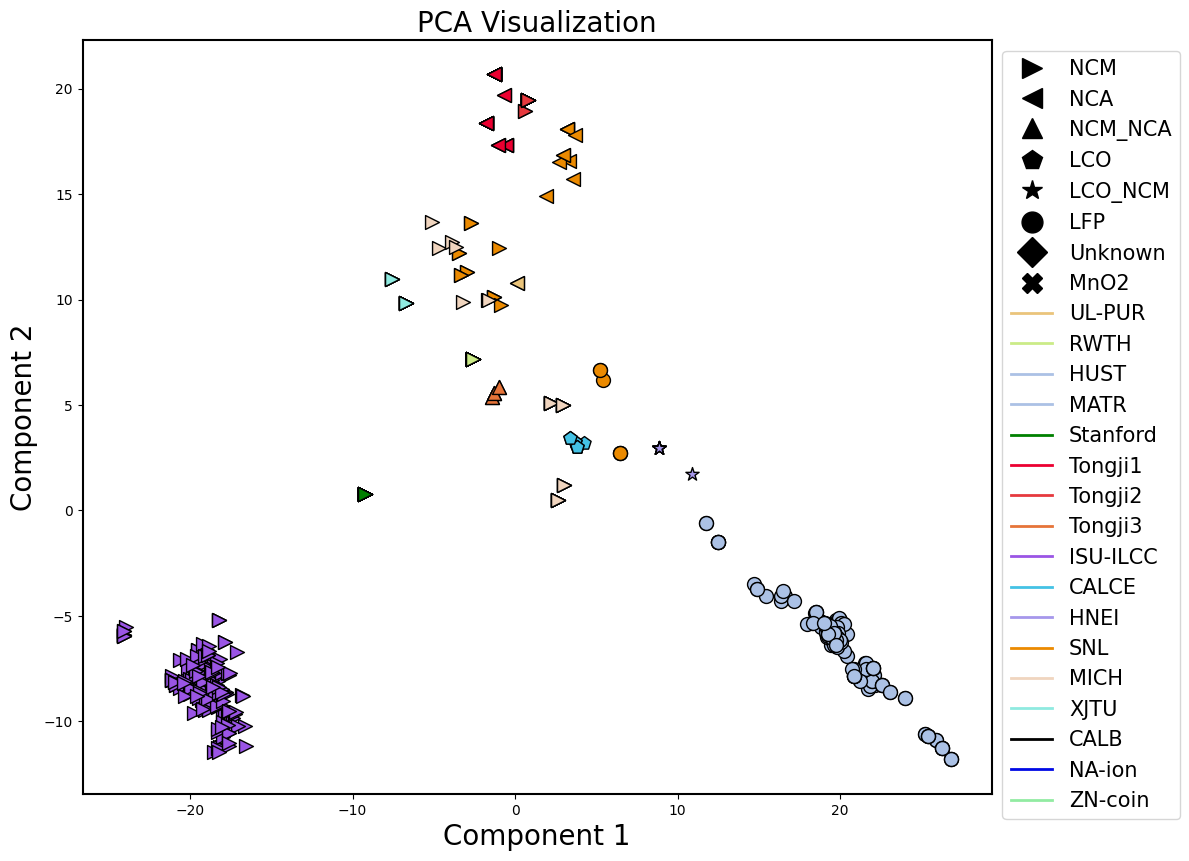

In [6]:
seed = 2021 # 2021, 42 ,2024
n_components = 0.99
# model_name = 'Qwen3_8B'
pretraining_cell_names = [i.split('.pkl')[0] for i in split_recorder.MIX_large_train_files]

data_path = f'/data/trf/python_works/BatteryLife/dataset/training_DKP_embed_all_{model_name}.pkl'
val_data_path = f'/data/trf/python_works/BatteryLife/dataset/validation_DKP_embed_all_{model_name}.pkl'
test_data_path = f'/data/trf/python_works/BatteryLife/dataset/testing_DKP_embed_all_{model_name}.pkl'


data = pickle.load(open(data_path, 'rb'))
val_data = pickle.load(open(val_data_path, 'rb'))
test_data = pickle.load(open(test_data_path, 'rb'))

pretraining_data = {}
for cell_name, value in data.items():
    if cell_name in pretraining_cell_names:
        pretraining_data[cell_name] = value

tmp_pretraining_features = np.array(list(pretraining_data.values())).squeeze(1) # only pretraining data is used to fit the PCA
tmp_train_total_features = np.array(list(data.values())).squeeze(1) # MIX_all_train
tmp_val_total_features = np.array(list(val_data.values())).squeeze(1)
tmp_test_total_features = np.array(list(test_data.values())).squeeze(1)
names = list(data.keys())


# Perform t-SNE on the embeddings (total_features)
pca = PCA(n_components=n_components, random_state=42)  # Reduce to 2D for visualization
pca_results = pca.fit_transform(tmp_pretraining_features)
print(f'The dimension is reduced to {pca_results.shape[1]} from {tmp_train_total_features.shape[1]}, and 99% information is kept.')
pca_train_results = pca.transform(tmp_train_total_features)
pca_val_results = pca.transform(tmp_val_total_features)
pca_test_results = pca.transform(tmp_test_total_features)

# save the PCA results for the prompt embeddings
train_pca_embeddings = {}
for i, key in enumerate(list(data.keys())):
    train_pca_embeddings[key] = pca_train_results[i, :].reshape(1, -1)

val_pca_embeddings = {}
for i, key in enumerate(list(val_data.keys())):
    val_pca_embeddings[key] = pca_val_results[i, :].reshape(1, -1)

test_pca_embeddings = {}
for i, key in enumerate(list(test_data.keys())):
    test_pca_embeddings[key] = pca_test_results[i, :].reshape(1, -1)

# save the results
pca_name = str(int(seed)) if seed != 2021 else ''
with open(f'/data/trf/python_works/BatteryLife/dataset/training_DKP_embed_all{pca_name}_pca_{model_name}.pkl', 'wb') as f:
    pickle.dump(train_pca_embeddings, f)
with open(f'/data/trf/python_works/BatteryLife/dataset/validation_DKP_embed_all{pca_name}_pca_{model_name}.pkl', 'wb') as f:
    pickle.dump(val_pca_embeddings, f)
with open(f'/data/trf/python_works/BatteryLife/dataset/testing_DKP_embed_all{pca_name}_pca_{model_name}.pkl', 'wb') as f:
    pickle.dump(test_pca_embeddings, f)

# Save the pretrained PCA
with open(f'/data/trf/python_works/BatteryLife/dataset/MIX_large_pca_{n_components}_{model_name}.pkl', 'wb') as f:
    pickle.dump(pca, f)


dataset_names = [name.split('_')[0] for name in names]

fig = plt.figure(figsize=(12, 9))
# Define a list of different shapes for the clusters
cathodes_data = json.load(open('./gate_data/cathodes.json'))
cathode_names = ['_'.join(cathodes_data[i+'.pkl']) for i in names]

dataset_shape_map = {
    'NCM': '>',
    'NCA': '<',
    'NCM_NCA':'^',
    'LCO': 'p',
    'LCO_NCM': '*',
    'LFP': 'o',
    'Unknown': 'D',
    'MnO2': 'X'
}

dataset_color = {
    'UL-PUR': '#EAC47B',
    'RWTH': '#CBEB87',
    'HUST':'#ABC1E5',
    'MATR': '#ABC1E5',
    'Stanford': 'green',
    'Tongji1': '#EB0031',
    'Tongji2': '#E6393E',
    'Tongji3': '#E67439',
    'ISU-ILCC': '#9A55E5',
    'CALCE': '#44C2E5',
    'HNEI': '#A697EB',
    'SNL': '#EB8A00',
    'MICH': '#F0D5BF',
    'XJTU': '#8FEAE0',
    'CALB': 'black',
    'NA-ion': '#0009E5',
    'ZN-coin': '#92EBA2'
}

appear_cathodeNames = []
for i in range(len(tmp_pretraining_features)):
    if cathode_names[i] not in appear_cathodeNames:
        plt.scatter(pca_results[i, 0], pca_results[i, 1],
                    c=dataset_color[dataset_names[i]],  # Color by cluster label
                    marker=dataset_shape_map[cathode_names[i]],  # Shape by dataset name
                     s=100, edgecolor='k', label=cathode_names[i])
    else:
        plt.scatter(pca_results[i, 0], pca_results[i, 1],
                    c=dataset_color[dataset_names[i]],  # Color by cluster label
                    marker=dataset_shape_map[cathode_names[i]],  # Shape by dataset name
                    s=100, edgecolor='k')
    appear_cathodeNames.append(cathode_names[i])

# Add labels and title
plt.title("PCA Visualization", fontsize=20)
plt.xlabel("Component 1", fontsize=20)
plt.ylabel("Component 2", fontsize=20)

# Custom legend for cluster shapes only (no color distinction)
legend_shapes = [Line2D([], [], marker=shape, color='black', linestyle='None', markersize=15, label=name) for name, shape in dataset_shape_map.items()]
legend_colors = [Line2D([], [], marker='None', color=color, linestyle='-', markersize=15, label=name, lw=2) for name, color in dataset_color.items()]
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1), fontsize=15, handles=legend_shapes+legend_colors)

set_ax_linewidth(plt.gca())
fig.tight_layout()
# plt.savefig('./figures/t-SNE_clustering.jpg', dpi=600, bbox_inches='tight')
plt.show()